In [ ]:
# plot histograms of characteristics of high-impact storms (in terms of absolute storm-induced anomalies in LOW RES full-field)
# Fig. 6 in paper 

In [1]:
import os
from tqdm import tqdm
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset, MFDataset
import numba as nb
import time as timing
from numba import njit 
from math import sin, cos, sqrt, atan2, radians
from geopy.distance import distance
import seawater as sw
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [2]:
#---
# CHOOSE YEARS to plot
#---

years = np.arange(1997,2018+1,1) 

#---
# SAVEPATH
#---

#---
# where to save plots?
#---
savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/'+\
                    'storm_anomalies_vs_deviations_from_clim/FIXED_DUPLICATES_v2/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    
savepath2     = savepath+'eps/'
# check existence of paths
if not os.path.exists(savepath2):
    print ('Created '+savepath2)
    os.makedirs(savepath2)
    
dpicnt = 150
save_plots    = True
display_plots = True


In [3]:
#---
# FUNCTION 
#---

def get_distance_to_storm_center(lat2,lon2,aux_lat,aux_lon):
                
    # create list of locations within 1000km of the storm
    points_data = []
    for pp in range(0,lat2.shape[0]):
        aux = (lat2[pp],lon2[pp])
        points_data.append(aux)
        del aux

    #print(len(points_data))
    # for each of these points get the distance to the storm center in km -> get distance in x-dir and y-dir
    points_distance_x = np.zeros(len(points_data)) # distance in longitudinal direction, i.e., use latitude of storm (aux_lat)
    points_distance_y = np.zeros(len(points_data)) # distance in latitudinal direction, i.e., use longitude of storm (aux_lon)
    for pp in range(0,len(points_data)): 
        # distance in longitudinal direction
        aux_point = (aux_lat,points_data[pp][1])
        points_distance_x[pp] = distance(point_storm, aux_point).km
       # print(aux_point,point_storm,points_distance_x[pp])
        # check sign: if lon grid cell is smaller (=further west) than lon of storm, define distance to be negative
        if points_data[pp][1]<aux_lon:
            points_distance_x[pp] = -1*points_distance_x[pp]
        elif (aux_lon<0) & (points_data[pp][1]>0): # lon_storm is east of dateline, but grid cell is west of dateline (grid cell is also further west in this case!)
            if (points_data[pp][1]-360)<aux_lon:
                points_distance_x[pp] = -1*points_distance_x[pp]
        del aux_point
        # distance in latitudinal direction
        aux_point = (points_data[pp][0],aux_lon)
        points_distance_y[pp] = distance(point_storm, aux_point).km
        # check sign: if lat grid cell is smaller (=further south) than lat of storm, define distance to be negative
        if points_data[pp][0]<aux_lat:
            points_distance_y[pp] = -1*points_distance_y[pp]
        del aux_point  
    return points_distance_x,points_distance_y,points_data
                    
    
def bin_points_as_distance_to_storm_center(counter,points_distance_x,points_distance_y,x_bins,y_bins,aux_data_anom,data_storm_mean,data_storm_std,data_storm_count):
    # data_storm_mean,data_storm_std,data_storm_count: initialized arrays, will be filled in this function and then returned
    
    # bin the points (account for where each point is relative to storm center)
    ind_x = np.digitize(points_distance_x,x_bins,right=False) # minimum is 1 (not zero!!)
    ind_y = np.digitize(points_distance_y,y_bins,right=False)
 #   print(np.min(ind_x),np.max(ind_x))
 #   print(np.min(ind_y),np.max(ind_y))
    # returned index satisfies: bins[i-1] <= x < bins[i]

   # print(aux_data_anom.shape)
    for xx in range(1,len(x_bins)+1): # start at 1 here -> see note above for ind_x
        for yy in range(1,len(x_bins)+1):
            index = np.where((ind_y==yy) & (ind_x==xx))[0]
            if len(index)>0:
                #if counter==6: 
                #    print(xx,yy,index.shape,aux_data_anom.shape)
                #if (counter==40) & (xx==11) & (yy==20):
                #    print(xx,yy,len(points_distance_x))
                #    print(index)
                #    print(index.shape,aux_data_anom.shape)
                # anomaly 2
                data_storm_mean[xx-1,yy-1]  = np.nanmean(aux_data_anom[index])
                data_storm_std[xx-1,yy-1]   = np.nanstd(aux_data_anom[index])
                data_storm_count[xx-1,yy-1] = index.shape[0]
            del index
    return data_storm_mean,data_storm_std,data_storm_count
    

In [4]:
#---
# LOAD COMPOSITES for totChl (low res/full, low res/emulator, high res)
#---

def get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,ratio_median,ratio_median_monthly):
    
    # get the median ratio for each year
    counter = 0
    for ss in range(0,data_storm_aux.shape[0]):
        aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
        if not np.isnan(aux_field):
            ratio_median[yy] = ratio_median[yy] + aux_field
            counter = counter+1
    ratio_median[yy] = np.divide(ratio_median[yy],counter)
    
    # get the median ratio for each year, EACH MONTH
    for mm in range(0,12):
        ind_mm = np.where(month_storm_aux==mm+1)[0]
        counter = 0
        for ss in ind_mm: 
            aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
            if not np.isnan(aux_field):
                ratio_median_monthly[yy,mm] = ratio_median_monthly[yy,mm] + aux_field
                counter = counter+1
        ratio_median_monthly[yy,mm] = np.divide(ratio_median_monthly[yy,mm],counter)
        
    return ratio_median,ratio_median_monthly

def grow_arrays(yy,year_list,data_storm_aux,data_dev_aux,month_storm_aux,lat_storm_aux,lon_storm_aux,slp_avg_storm_aux,slp_min_storm_aux,\
                                                           data_storm,data_dev,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm,year_storm): 
    if yy==0:
        data_storm  = data_storm_aux
        data_dev    = data_dev_aux
        month_storm = month_storm_aux
        lat_storm   = lat_storm_aux
        lon_storm   = lon_storm_aux
        slp_min_storm   = slp_min_storm_aux
        slp_avg_storm   = slp_avg_storm_aux
        year_storm = year_list[yy]*np.ones(data_storm_aux.shape[0])
    else:
        data_storm  = np.concatenate((data_storm,data_storm_aux))
        data_dev    = np.concatenate((data_dev,data_dev_aux))
        month_storm = np.concatenate((month_storm,month_storm_aux))
        lat_storm   = np.concatenate((lat_storm,lat_storm_aux))
        lon_storm   = np.concatenate((lon_storm,lon_storm_aux))
        slp_min_storm   = np.concatenate((slp_min_storm,slp_min_storm_aux))
        slp_avg_storm   = np.concatenate((slp_avg_storm,slp_avg_storm_aux))
        year_storm  = np.concatenate((year_storm,year_list[yy]*np.ones(data_storm_aux.shape[0])))
                
    return data_storm,data_dev,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm,year_storm

def load_data(path1a,path1b,file1,file3,vari1a,vari1b): 
    # storm-induced anomaly
    ff  = xr.open_dataset(path1a+file1)
    data_storm_aux  = ff[vari1a+'_storm_anomaly4_mean'].values 
    month_storm_aux = ff['month_storm'].values  # at min. SLP
    day_storm_aux   = ff['day_storm'].values  # at min. SLP
    year_storm_aux  = ff['year_storm'].values  # at min. SLP
    lat_storm_aux   = ff['lat_storm'].values  # at min. SLP
    lon_storm_aux   = ff['lon_storm'].values  # at min. SLP
    slp_avg_storm_aux   = ff['avg_min_slp_storm'].values  # avg of all min SLP over all time steps of the storm's existence 
    slp_min_storm_aux   = ff['min_min_slp_storm'].values  # min. SLP over all time steps of the storm's existence 
    ff.close()
    data_storm_aux[data_storm_aux==0] = np.nan
    
    # deviations from climatology
    ff  = xr.open_dataset(path1b+file3)
    data_dev_aux = ff[vari1b+'_storm_anomaly4_mean'].values 
    ff.close()
    data_dev_aux[data_dev_aux==0] = np.nan
    
    return data_storm_aux,day_storm_aux,month_storm_aux,year_storm_aux,\
                lat_storm_aux,lon_storm_aux,data_dev_aux,slp_avg_storm_aux,slp_min_storm_aux
    

year_list = np.arange(1997,2018+1,1)

vari = 'totChl'
path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_anomalies/'
path2 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_emulator_anomalies/'
path3 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_hr_anomalies/'
    
# what's the median ratio between storm-induced anomalies and deviations from clim?
ratio_median            = np.zeros([len(year_list)]) 
ratio_median_monthly    = np.zeros([len(year_list),12])
ratio_median_em         = np.zeros([len(year_list)]) 
ratio_median_monthly_em = np.zeros([len(year_list),12])
ratio_median_hr         = np.zeros([len(year_list)]) 
ratio_median_monthly_hr = np.zeros([len(year_list),12])
# initilize variables (will be overwritten!)
#data_storm,data_dev,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm,year_storm = [],[],[],[],[],[],[],[]
#data_storm_em,data_dev_em,month_storm_em,lat_storm_em,lon_storm_em,slp_avg_storm_em,slp_min_storm_em,year_storm_em = [],[],[],[],[],[],[],[]
#data_storm_hr,data_dev_hr,month_storm_hr,lat_storm_hr,lon_storm_hr,slp_avg_storm_hr,slp_min_storm_hr,year_storm_hr = [],[],[],[],[],[],[],[]

#----
# LOW RES, FULL FIELD
#----
    
# storm-induced anomaly
file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc'
# deviations from climatology
file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc'

# load data
data_storm,day_storm,month_storm,year_storm,lat_storm,lon_storm,\
            data_dev,slp_avg_storm,slp_min_storm = load_data(path1,path1,file1,file3,vari,vari)
    
## get median ratio for each year (& month) individually (--> look at variability of median across years/months!)
#ratio_median,ratio_median_monthly = get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,\
#                                                         ratio_median,ratio_median_monthly)
        
#----
# LOW RES, EMULATOR
#----
    
# storm-induced anomaly
#file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_emulator_'+\
#            str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc'
file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_emulator_'+\
            str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc' # in TEST folder, this is the file using the full-field clim
# deviations from climatology
file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc' # uses full-field clim

# storm-induced anomaly


# load data
data_storm_em,day_storm_em,month_storm_em,year_storm_em,lat_storm_em,lon_storm_em,\
            data_dev_em,slp_avg_storm_em,slp_min_storm_em = load_data(path2+'TEST/',path1,file1,file3,vari+'_emulator',vari)
    
## get median ratio for each year (& month) individually (--> look at variability of median across years/months!)
#ratio_median_em,ratio_median_monthly_em = get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,\
#                                                         ratio_median_em,ratio_median_monthly_em)
    
    
    
plot_hr = True
if plot_hr:
    #----
    # HIGH RES, FULL FIELD
    #----

    # storm-induced anomaly
    file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_hr_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc'
    # deviations from climatology
    file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_hr_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc'

    # load data
    data_storm_hr,day_storm_hr,month_storm_hr,year_storm_hr,lat_storm_hr,lon_storm_hr,\
                data_dev_hr,slp_avg_storm_hr,slp_min_storm_hr = load_data(path3,path3,file1,file3,vari,vari)

    ## get median ratio for each year (& month) individually (--> look at variability of median across years/months!)
    #ratio_median_hr,ratio_median_monthly_hr = get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,\
    #                                                     ratio_median_hr,ratio_median_monthly_hr)

    print(data_storm_hr.shape,data_dev_hr.shape)
    
print(data_storm.shape,data_dev.shape)
print(data_storm_em.shape,data_dev_em.shape)



#----
# make sure that the same storms are considered in LOW RES and HIGH RES
#----

data_aux_mean = np.nanmean(np.nanmean(data_storm,axis=2),axis=1)
ind_no_NaN = np.where(~np.isnan(data_aux_mean))[0]
ind_no_NaN_lr = np.copy(ind_no_NaN) # for wind speeds further down

data_storm     = data_storm[ind_no_NaN,:,:]
data_storm_em  = data_storm_em[ind_no_NaN,:,:]
if plot_hr:
    data_storm_hr  = data_storm_hr[ind_no_NaN,:,:]
data_dev     = data_dev[ind_no_NaN,:,:]
data_dev_em  = data_dev_em[ind_no_NaN,:,:]
if plot_hr:
    data_dev_hr  = data_dev_hr[ind_no_NaN,:,:]

month_storm = month_storm[ind_no_NaN]
year_storm  = year_storm[ind_no_NaN]
lat_storm   = lat_storm[ind_no_NaN]
lon_storm   = lon_storm[ind_no_NaN]
slp_avg_storm = slp_avg_storm[ind_no_NaN]
slp_min_storm = slp_min_storm[ind_no_NaN]

if plot_hr:
    month_storm_hr = month_storm_hr[ind_no_NaN]
    year_storm_hr  = year_storm_hr[ind_no_NaN]
    lat_storm_hr   = lat_storm_hr[ind_no_NaN]
    lon_storm_hr   = lon_storm_hr[ind_no_NaN]
    slp_avg_storm_hr = slp_avg_storm_hr[ind_no_NaN]
    slp_min_storm_hr = slp_min_storm_hr[ind_no_NaN]

month_storm_em = month_storm_em[ind_no_NaN]
year_storm_em  = year_storm_em[ind_no_NaN]
lat_storm_em   = lat_storm_em[ind_no_NaN]
lon_storm_em   = lon_storm_em[ind_no_NaN]
slp_avg_storm_em = slp_avg_storm_em[ind_no_NaN]
slp_min_storm_em = slp_min_storm_em[ind_no_NaN]

print('data_storm_em.shape',data_storm_em.shape)
if plot_hr:
    print('data_storm_hr.shape',data_storm_hr.shape)
print('data_storm.shape',data_storm.shape)


(9615, 21, 21) (9615, 21, 21)
(9615, 21, 21) (9615, 21, 21)
(9615, 21, 21) (9615, 21, 21)
data_storm_em.shape (9554, 21, 21)
data_storm_hr.shape (9554, 21, 21)
data_storm.shape (9554, 21, 21)


/tmp/ipykernel_2334023/3646150046.py:172: RuntimeWarning: Mean of empty slice
  data_aux_mean = np.nanmean(np.nanmean(data_storm,axis=2),axis=1)


In [5]:
#---
# STRONGST STORMS
#---

# Quantify the average relative imprint of each storm on surface chlorophyll (expressed as % relative to deviations from seasonal cycle). 
# Compare the minimum SLP of these storms to the strongest storms as per the above definition. How different are they? 

num_storms = data_storm.shape[0]

ratio    = np.zeros([num_storms])
ratio_hr = np.zeros([num_storms])
ratio_em = np.zeros([num_storms])
data_avg    = np.zeros([num_storms])
data_avg_hr = np.zeros([num_storms])
data_avg_em = np.zeros([num_storms])
for tt in range(0,num_storms):
    ratio[tt]    = 100*np.nanmean(data_storm[tt,:,:])/np.nanmean(data_dev[tt,:,:])
    ratio_em[tt] = 100*np.nanmean(data_storm_em[tt,:,:])/np.nanmean(data_dev_em[tt,:,:])
    ratio_hr[tt] = 100*np.nanmean(data_storm_hr[tt,:,:])/np.nanmean(data_dev_hr[tt,:,:])
    data_avg[tt]    = np.nanmean(data_storm[tt,:,:])
    data_avg_em[tt] = np.nanmean(data_storm_em[tt,:,:])
    data_avg_hr[tt] = np.nanmean(data_storm_hr[tt,:,:])


/tmp/ipykernel_2334023/1059963442.py:18: RuntimeWarning: Mean of empty slice
  ratio_em[tt] = 100*np.nanmean(data_storm_em[tt,:,:])/np.nanmean(data_dev_em[tt,:,:])
/tmp/ipykernel_2334023/1059963442.py:21: RuntimeWarning: Mean of empty slice
  data_avg_em[tt] = np.nanmean(data_storm_em[tt,:,:])


In [9]:
#---
# strongest anomalies only (irrespective of the sign) 
# -> taking absolute should ensure I only have storms during growing season, right? CHECK what months the "strong storms" are in
#---
# Where and when do the storms with the strongest negative chl anomaly occur?
# Where and when do the storms with the strongest positive chl anomaly occur?
# --> can I detect any pattern?

# get max. wind speed

def load_data(path1a,file1,vari1a): 
    # storm-induced anomaly
    ff  = xr.open_dataset(path1a+file1)
    wind_storm_aux1   = ff['avg_max_wind_storm'].values  
    wind_storm_aux2   = ff['max_max_wind_storm'].values  
    ff.close()
    wind_storm_aux1[wind_storm_aux1==0]=np.nan
    wind_storm_aux2[wind_storm_aux2==0]=np.nan
        
    return wind_storm_aux1,wind_storm_aux2

def grow_arrays(yy,wind_storm_aux1,wind_storm_aux2,max_wind_storm,avg_wind_storm): 
    if yy==0:
        avg_wind_storm  = wind_storm_aux1 # avg. max. wind over each time step of the storm's existence
        max_wind_storm  = wind_storm_aux2 # max. wind over the storm's existence
    else:
        avg_wind_storm  = np.concatenate((avg_wind_storm,wind_storm_aux1))
        max_wind_storm  = np.concatenate((max_wind_storm,wind_storm_aux2))
        
    return max_wind_storm,avg_wind_storm

year_list = np.arange(1997,2018+1,1)

vari = 'totChl'
path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_anomalies/'
path2 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_emulator_anomalies/'
path3 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_hr_anomalies/'
    
#----
# LOW RES, FULL FIELD
#----
    
# storm-induced anomaly
file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first_wind_speeds.nc'
    
# load data
max_wind_storm,avg_wind_storm = load_data(path1,file1,vari)
    
    
print(max_wind_storm.shape)
print(avg_wind_storm.shape)

#data_aux = np.nanmean(np.nanmean(max_wind_storm,axis=2),axis=1)
#ind_no_NaN = np.where(~np.isnan(max_wind_storm))[0]

# make sure to only consider the same storms considered above
max_wind_storm = max_wind_storm[ind_no_NaN_lr]
avg_wind_storm = avg_wind_storm[ind_no_NaN_lr]

print(max_wind_storm.shape)
print(avg_wind_storm.shape)


(9615,)
(9615,)
(9554,)
(9554,)


In [10]:
print(data_dev.shape)
print(data_avg.shape)
print(ratio.shape)

(9554, 21, 21)
(9554,)
(9554,)


In [11]:
#----
# FUNCTIONS
#---
# see: https://stackoverflow.com/questions/620305/convert-year-month-day-to-day-of-year-in-python

def is_leap_year(year):
    """ if year is a leap year return True
        else return False """
    if year % 100 == 0:
        return year % 400 == 0
    return year % 4 == 0

def doy(Y,M,D):
    """ given year, month, day return day of year
        Astronomical Algorithms, Jean Meeus, 2d ed, 1998, chap 7 """
    if is_leap_year(Y):
        K = 1
    else:
        K = 2
    N = int((275 * M) / 9.0) - K * int((M + 9) / 12.0) + D - 30
    return N

def ymd(Y,N):
    """ given year = Y and day of year = N, return year, month, day
        Astronomical Algorithms, Jean Meeus, 2d ed, 1998, chap 7 """    
    if is_leap_year(Y):
        K = 1
    else:
        K = 2
    M = int((9 * (K + N)) / 275.0 + 0.98)
    if N < 32:
        M = 1
    D = N - int((275 * M) / 9.0) + K * int((M + 9) / 12.0) + 30
    return Y, M, D



956  storms
956  storms
1.0 365.0
1.0 366.0


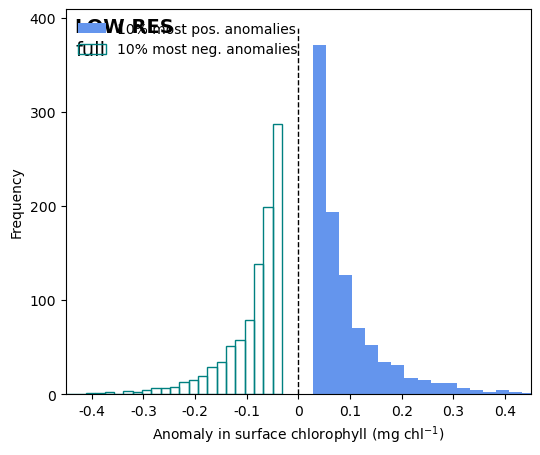

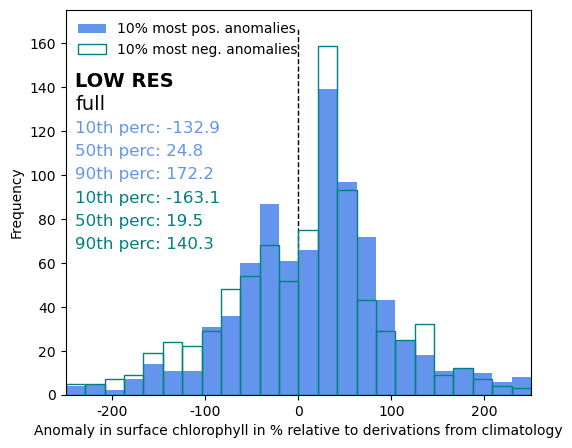

0 pos/neg: 23.01255230125523 17.782426778242677
1 pos/neg: 6.066945606694561 4.707112970711297
2 pos/neg: 0.8368200836820083 0.41841004184100417
3 pos/neg: 0.0 0.0
4 pos/neg: 0.0 0.0
5 pos/neg: 0.0 0.0
6 pos/neg: 0.0 0.0
7 pos/neg: 0.7322175732217573 0.10460251046025104
8 pos/neg: 5.334728033472803 3.5564853556485354
9 pos/neg: 14.121338912133892 18.09623430962343
10 pos/neg: 22.803347280334727 27.615062761506277
11 pos/neg: 27.09205020920502 27.719665271966527

Jan-Mar, pos/neg: 29.9163179916318 22.907949790794977
Apr-Jul, pos/neg: 0.0 0.0
Aug-Sep, pos/neg: 6.066945606694561 3.6610878661087867
Oct-Dec, pos/neg: 64.01673640167364 73.43096234309624

Oct-Jan, pos/neg: 87.02928870292887 91.21338912133892


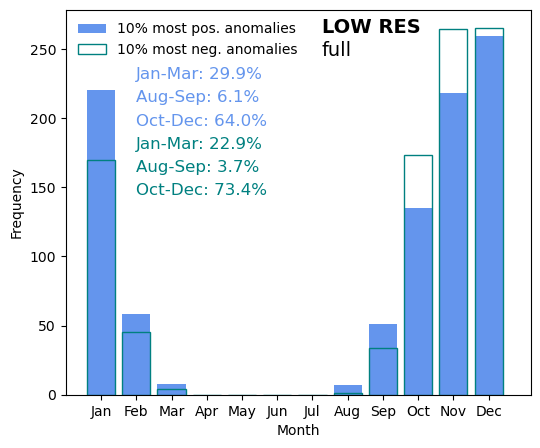

(38,)


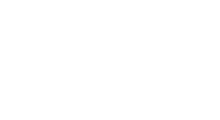

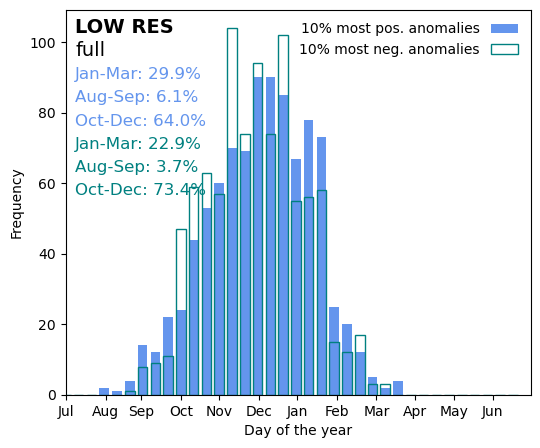

10th, pos/neg: 15.405930519104004 14.240186214447021
25th, pos/neg: 16.73154306411743 15.66903305053711
50th, pos/neg: 18.490619659423828 17.39762306213379
75th, pos/neg: 20.31092405319214 19.290814876556396
90th, pos/neg: 22.103057861328125 21.36068344116211


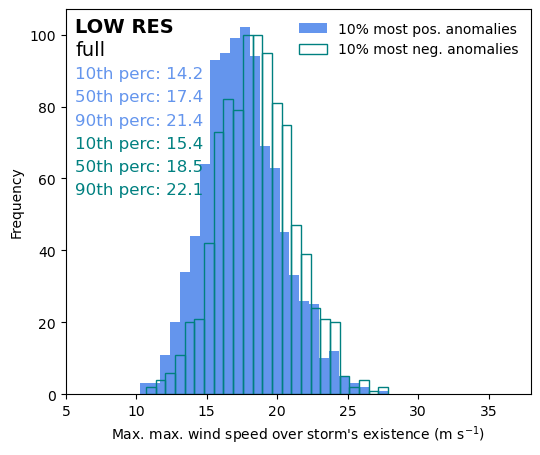

10th, pos/neg: 11.196589946746826 10.769520282745361
25th, pos/neg: 12.825400352478027 12.183122158050537
50th, pos/neg: 14.729264736175537 13.939090251922607
75th, pos/neg: 16.83458662033081 15.940062761306763
90th, pos/neg: 18.816490173339844 17.78786563873291


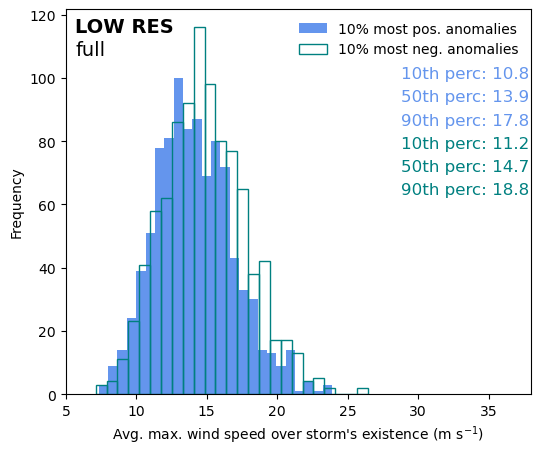

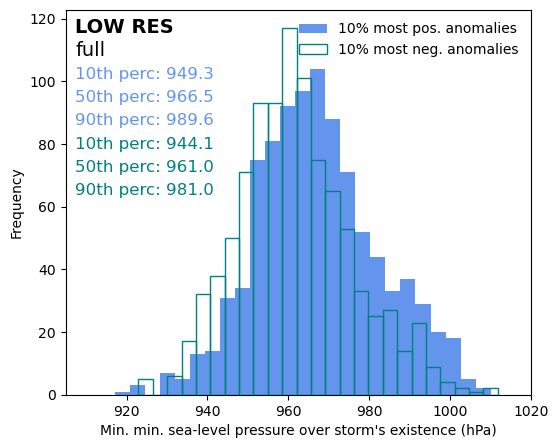

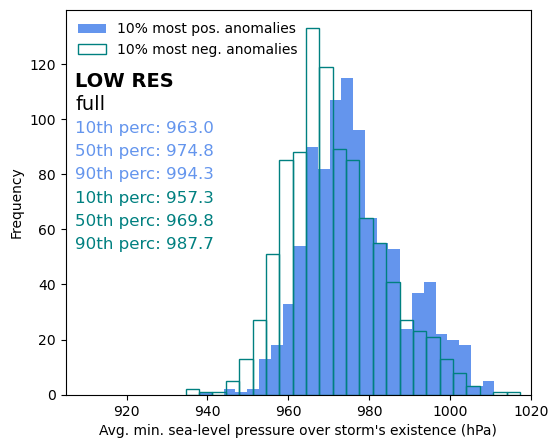

10th, pos/neg: -67.67533874511719 -68.23695373535156
25th, pos/neg: -63.18238830566406 -63.7440071105957
50th, pos/neg: -58.68943405151367 -59.81267166137695
75th, pos/neg: -53.634849548339844 -54.75809097290039
90th, pos/neg: -46.89540100097656 -49.141883850097656


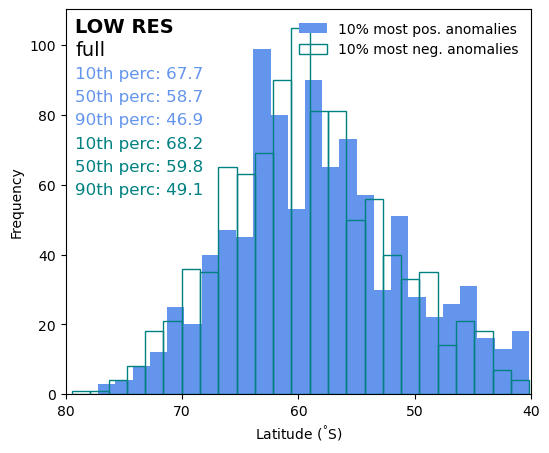

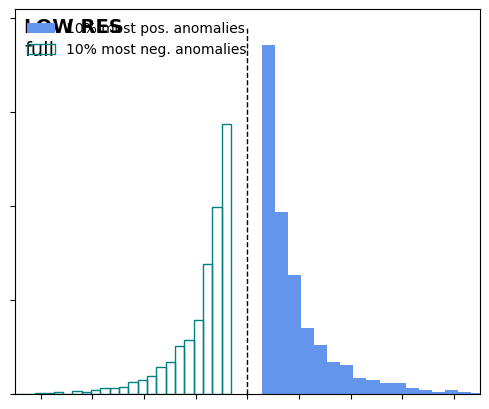

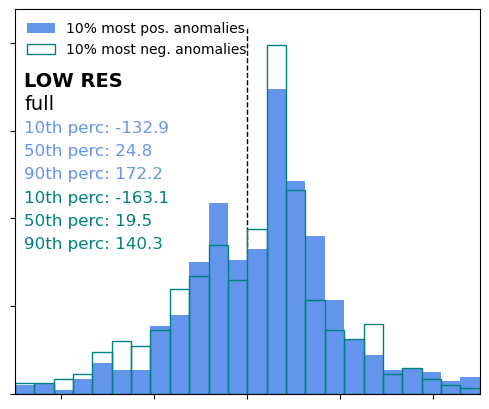

0 pos/neg: 23.01255230125523 17.782426778242677
1 pos/neg: 6.066945606694561 4.707112970711297
2 pos/neg: 0.8368200836820083 0.41841004184100417
3 pos/neg: 0.0 0.0
4 pos/neg: 0.0 0.0
5 pos/neg: 0.0 0.0
6 pos/neg: 0.0 0.0
7 pos/neg: 0.7322175732217573 0.10460251046025104
8 pos/neg: 5.334728033472803 3.5564853556485354
9 pos/neg: 14.121338912133892 18.09623430962343
10 pos/neg: 22.803347280334727 27.615062761506277
11 pos/neg: 27.09205020920502 27.719665271966527


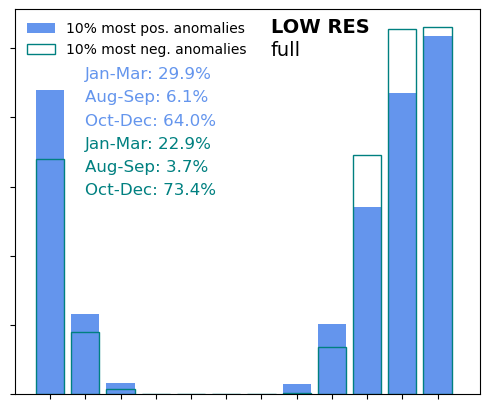

(38,)


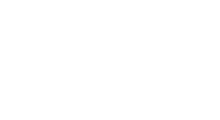

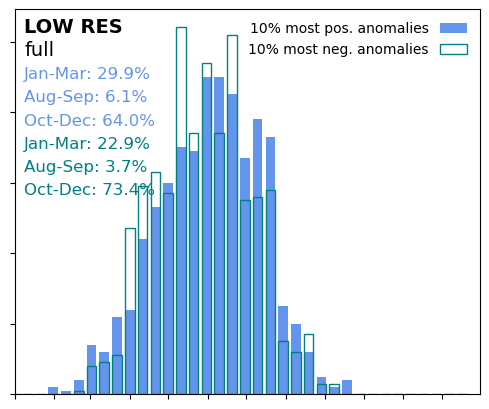

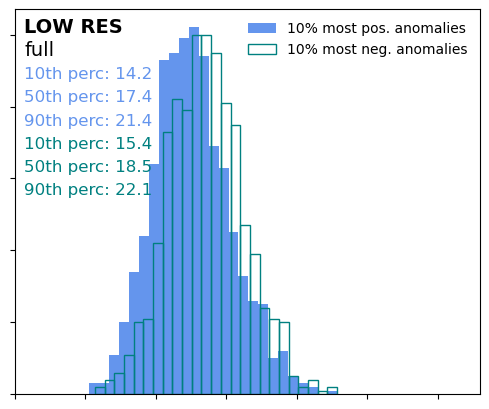

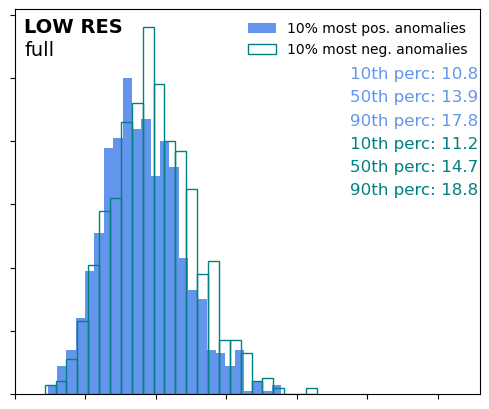

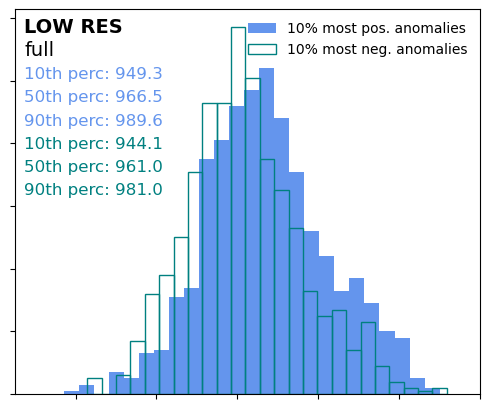

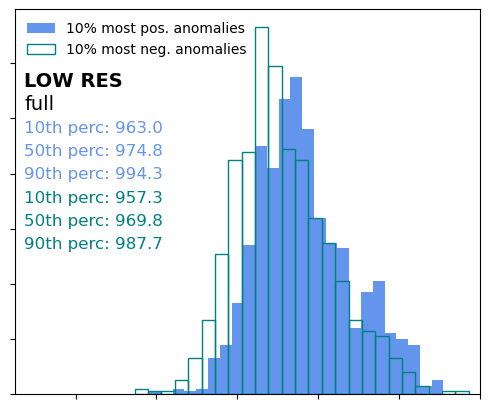

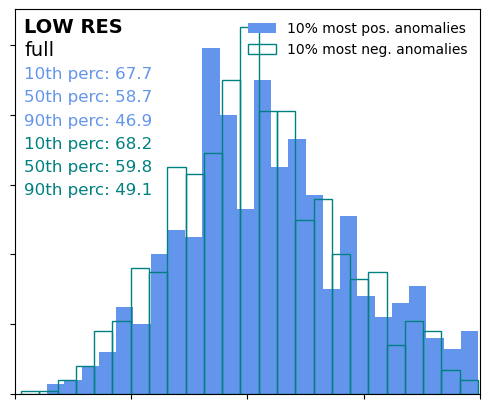

In [12]:
#---
# strongest anomalies only (positive or negative in sign), LOW RES
#---
# Where and when do the storms with the strongest negative chl anomaly occur?
# Where and when do the storms with the strongest positive chl anomaly occur?
# --> can I detect any pattern?
# --> What is their min SLP? What is their max wind speed?
#
# strongest storms are in winter, but strongest chl signal is in summer!
# negative anomalies are more likely early in the growing season
# 
#

perc1 = 10
perc2 = 90

fs = 12

# find storms of interest based on chl anomalies
ind_no_NaN = np.where(~np.isnan(data_avg))[0]
thrsh1 = np.percentile(data_avg[ind_no_NaN],perc1) # 10% with largest negative anomaly
thrsh2 = np.percentile(data_avg[ind_no_NaN],perc2) # 10% with largest positive anomaly
ind_strong1 = np.where(data_avg[ind_no_NaN]<=thrsh1)[0]
ind_strong2 = np.where(data_avg[ind_no_NaN]>=thrsh2)[0]

print(ind_strong1.shape[0],' storms')
print(ind_strong2.shape[0],' storms')

# 10% with largest positive anomaly
aux_slp1  = slp_min_storm[ind_no_NaN][ind_strong2]
aux_slp2  = slp_avg_storm[ind_no_NaN][ind_strong2]
aux_lat   = lat_storm[ind_no_NaN][ind_strong2]
aux_lon   = lon_storm[ind_no_NaN][ind_strong2]
aux_month = month_storm[ind_no_NaN][ind_strong2]
aux_day   = day_storm[ind_no_NaN][ind_strong2]
aux_year  = year_storm[ind_no_NaN][ind_strong2]
aux_chl   = data_avg[ind_no_NaN][ind_strong2]
aux_ratio = ratio[ind_no_NaN][ind_strong2]
aux_wind1  = max_wind_storm[ind_no_NaN][ind_strong2]
aux_wind2  = avg_wind_storm[ind_no_NaN][ind_strong2]
    
# negative anomalies (to plot on top)
aux_slp1_b  = slp_min_storm[ind_no_NaN][ind_strong1]
aux_slp2_b  = slp_avg_storm[ind_no_NaN][ind_strong1]
aux_lat_b   = lat_storm[ind_no_NaN][ind_strong1]
aux_lon_b   = lon_storm[ind_no_NaN][ind_strong1]
aux_chl_b   = data_avg[ind_no_NaN][ind_strong1]
aux_ratio_b = ratio[ind_no_NaN][ind_strong1]
aux_month_b = month_storm[ind_no_NaN][ind_strong1]
aux_day_b   = day_storm[ind_no_NaN][ind_strong1]
aux_year_b  = year_storm[ind_no_NaN][ind_strong1]
aux_lat_b   = lat_storm[ind_no_NaN][ind_strong1]
aux_wind1_b  = max_wind_storm[ind_no_NaN][ind_strong1]
aux_wind2_b  = avg_wind_storm[ind_no_NaN][ind_strong1]


# get day of the year
day_of_year = np.zeros([len(aux_year)])
for tt in range(0,len(aux_year)):
    day_of_year[tt]   = doy(int(aux_year[tt]),int(aux_month[tt]),int(aux_day[tt]))

day_of_year_b = np.zeros([len(aux_year_b)])
for tt in range(0,len(aux_year)):
    day_of_year_b[tt]   = doy(int(aux_year_b[tt]),int(aux_month_b[tt]),int(aux_day_b[tt]))

print(np.min(day_of_year),np.max(day_of_year))
print(np.min(day_of_year_b),np.max(day_of_year_b))


name_string = 'LOW RES'
name_string2 = 'full'

#---
# MAP of storm positions
#---

color0 = 'darkblue' # positive
color1 = 'cornflowerblue' # positive
color2 = 'teal' # negative
ms = 1.5

plot_map = False
if plot_map:
    fig = plt.figure(figsize=(18,7)) # x, y
    #  ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) 
    #ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()
    ax.coastlines()
    ax.set_extent([-179, 179, -90, -40])
    #------
    # positive anomalies
    for nn in range(0,aux_lat.shape[0]):
        plt.plot(aux_lon[nn], aux_lat[nn],color=color0, marker='o',markersize=ms,transform=ccrs.Geodetic())
    # negative anomalies
    for nn in range(0,aux_lat_b.shape[0]):
        plt.plot(aux_lon_b[nn], aux_lat_b[nn],color=color2, marker='o',markersize=ms,transform=ccrs.Geodetic())
    #------
    ax.yaxis.tick_left()
    ax.set_xticks([-180,-120, -60, 0, 60, 120, 180],crs=ccrs.PlateCarree())
    ax.set_yticks([-60, -40], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    if save_plots:
        filename = 'Map_storm_centers_at_peak_intensity_strongest_'+str(perc1+(100-perc2))+\
                        'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_chl_anom.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    plt.show()

#---
# PLOT
#---

num_bins = 25

fig = plt.figure(figsize=(6,5))
plt.hist(aux_chl,bins=num_bins,color=color1,label=str(100-perc2)+'% most pos. anomalies')
plt.hist(aux_chl_b,bins=num_bins,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
#plt.vlines(np.percentile(aux_chl,10),0,300,color=color2,linestyle='--')
#plt.vlines(np.percentile(aux_chl,25),0,300,color=color2,linestyle='--')
#plt.vlines(np.percentile(aux_chl,50),0,300,color=color2,linestyle='-')
#plt.vlines(np.percentile(aux_chl,75),0,300,color=color2,linestyle=':')
#plt.vlines(np.percentile(aux_chl,90),0,300,color=color2,linestyle=':')
plt.legend(frameon=False)
plt.ylabel('Frequency')
plt.xlabel('Anomaly in surface chlorophyll (mg chl$^{-1}$)')
plt.annotate(name_string,xy=(0.02,0.94),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
plt.annotate(name_string2,xy=(0.02,0.88),xycoords='axes fraction',fontsize=fs+2,ha='left') 
ylim1,ylim2=plt.gca().get_ylim()
plt.vlines(0,ylim1,ylim2,color='k',linewidth=1,linestyle='--',zorder=0)
plt.yticks([0,100,200,300,400],[0,100,200,300,400])
plt.xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4],[-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
#plt.xticks([-0.4,-0.2,0,0.2,0.4,0.6],[-0.4,-0.2,0,0.2,0.4,0.6])
plt.xlim((-0.45,0.45))
if save_plots:
    filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                    'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_chl_anom.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    

# relative to derivation from climatology
bins_deriv = np.linspace(-250,250,25)
fig = plt.figure(figsize=(6,5))
plt.hist(aux_ratio,bins=bins_deriv,color=color1,label=str(100-perc2)+'% most pos. anomalies')
plt.hist(aux_ratio_b,bins=bins_deriv,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
plt.legend(frameon=False)
plt.xlim((-250,250))
plt.ylabel('Frequency')
plt.xlabel('Anomaly in surface chlorophyll in % relative to derivations from climatology')
plt.annotate(name_string,xy=(0.02,0.80),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
plt.annotate(name_string2,xy=(0.02,0.74),xycoords='axes fraction',fontsize=fs+2,ha='left') 
ylim1,ylim2=plt.gca().get_ylim()
plt.vlines(0,ylim1,ylim2,color='k',linewidth=1,linestyle='--',zorder=0)
#plt.yticks([0,40,80,120,160],[0,40,80,120,160])
plt.xticks([-200,-100,0,100,200],[-200,-100,0,100,200])
# pos anomalies
plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_ratio,10))/10),xy=(0.02,0.68),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_ratio,50))/10),xy=(0.02,0.62),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_ratio,90))/10),xy=(0.02,0.56),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
# neg anomalies
plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_ratio_b,10))/10),xy=(0.02,0.50),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_ratio_b,50))/10),xy=(0.02,0.44),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_ratio_b,90))/10),xy=(0.02,0.38),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
if save_plots:
    filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                    'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_chl_anom_rel_to_derivations_from_clim.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)

    
    
# How many % are in each month?
perc_monthly_neg = np.zeros([12])
perc_monthly_pos = np.zeros([12])
for mm in range(0,12):
    ind_mm = np.where(aux_month==mm+1)[0] # POSITIVE
    perc_monthly_pos[mm] = 100*ind_mm.shape[0]/aux_month.shape[0]
    del ind_mm
    ind_mm = np.where(aux_month_b==mm+1)[0] # NEGATIVE
    perc_monthly_neg[mm] = 100*ind_mm.shape[0]/aux_month_b.shape[0]
    del ind_mm
for mm in range(0,12):
    print(mm,'pos/neg:',perc_monthly_pos[mm],perc_monthly_neg[mm])
    
print()
print('Jan-Mar, pos/neg:',np.sum(perc_monthly_pos[0:2+1]),np.sum(perc_monthly_neg[0:2+1]))
print('Apr-Jul, pos/neg:',np.sum(perc_monthly_pos[3:6+1]),np.sum(perc_monthly_neg[3:6+1]))
print('Aug-Sep, pos/neg:',np.sum(perc_monthly_pos[7:8+1]),np.sum(perc_monthly_neg[7:8+1]))
print('Oct-Dec, pos/neg:',np.sum(perc_monthly_pos[9:11+1]),np.sum(perc_monthly_neg[9:11+1]))
print()
print('Oct-Jan, pos/neg:',np.sum(perc_monthly_pos[9:11+1])+perc_monthly_pos[0],np.sum(perc_monthly_neg[9:11+1])+perc_monthly_neg[0])
    
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig = plt.figure(figsize=(6,5))
plt.hist(aux_month,bins=range(1,13+1),width=0.8,color=color1,label=str(100-perc2)+'% most pos. anomalies')
plt.hist(aux_month_b,bins=range(1,13+1),width=0.8,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
plt.legend(frameon=False)
plt.ylabel('Frequency')
plt.xlabel('Month')
plt.xticks(np.arange(1+0.4,13+0.4),months)
plt.yticks([0,50,100,150,200,250],[0,50,100,150,200,250])
plt.annotate(name_string,xy=(0.55,0.94),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
plt.annotate(name_string2,xy=(0.55,0.88),xycoords='axes fraction',fontsize=fs+2,ha='left') 
# pos anomalies
plt.annotate('Jan-Mar: '+str(np.round(10*np.sum(perc_monthly_pos[0:2+1]))/10)+'%',xy=(0.15,0.82),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('Aug-Sep: '+str(np.round(10*np.sum(perc_monthly_pos[7:8+1]))/10)+'%',xy=(0.15,0.76),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('Oct-Dec: '+str(np.round(10*np.sum(perc_monthly_pos[9:11+1]))/10)+'%',xy=(0.15,0.70),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
# neg anomalies
plt.annotate('Jan-Mar: '+str(np.round(10*np.sum(perc_monthly_neg[0:2+1]))/10)+'%',xy=(0.15,0.64),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('Aug-Sep: '+str(np.round(10*np.sum(perc_monthly_neg[7:8+1]))/10)+'%',xy=(0.15,0.58),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('Oct-Dec: '+str(np.round(10*np.sum(perc_monthly_neg[9:11+1]))/10)+'%',xy=(0.15,0.52),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
if save_plots:
    filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                    'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_month.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
# DAY OF THE YEAR
#----
# reverse order in plotting
#----

def reorder_months(data):
    data2 = np.copy(data)
    data2[0:19] = data[19:]
    data2[19:] = data[0:19]
    return data2

days_per_month = [1,31,28,31,30,31,30,31,31,30,31,30,31]
months_rev = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
color2 = 'teal' 

res = 10
print(np.arange(1,366+res,res).shape)
# DAY OF THE YEAR
fig = plt.figure(figsize=(2,1))
(n1, bins1, patches1) = plt.hist(day_of_year,bins=np.arange(1,366,res),width=res*0.9,\
         color=color1,label=str(100-perc2)+'% most pos. anomalies')
(n2, bins2, patches2) = plt.hist(day_of_year_b,bins=np.arange(1,366,res),width=res*0.9,\
         color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
plt.gca().set_visible(False)
plt.show()

fig = plt.figure(figsize=(6,5))
#plt.bar(bins1[:-1],n1,width=res*0.9,color=color1,label=str(100-perc2)+'% most pos. anomalies')
#plt.bar(bins2[:-1],n2,width=res*0.9,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
#plt.bar(np.concatenate((bins1[:-1][18:],bins1[:-1][0:18])),np.concatenate((n1[18:],n1[0:18])),\
#        width=res*0.9,color=color1,label=str(100-perc2)+'% most pos. anomalies')
#plt.bar(np.concatenate((bins2[:-1][18:],bins2[:-1][0:18])),np.concatenate((n2[18:],n2[0:18])),\
#        width=res*0.9,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
plt.bar(bins1[:-1],np.concatenate((n1[18:],n1[0:18])),\
        width=res*0.75,color=color1,label=str(100-perc2)+'% most pos. anomalies')
plt.bar(bins2[:-1],np.concatenate((n2[18:],n2[0:18])),\
        width=res*0.75,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
plt.legend(frameon=False,markerfirst=False)
plt.ylabel('Frequency')
plt.xlabel('Day of the year')
plt.xticks(np.cumsum(days_per_month)[:-1],months_rev)
plt.xlim((1,365))
#plt.xticks(np.arange(1+0.4,13+0.4),months)
plt.yticks([0,20,40,60,80,100],[0,20,40,60,80,100])
plt.annotate(name_string,xy=(0.02,0.94),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
plt.annotate(name_string2,xy=(0.02,0.88),xycoords='axes fraction',fontsize=fs+2,ha='left') 
xpos = 0.02
# pos anomalies
plt.annotate('Jan-Mar: '+str(np.round(10*np.sum(perc_monthly_pos[0:2+1]))/10)+'%',xy=(xpos,0.82),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('Aug-Sep: '+str(np.round(10*np.sum(perc_monthly_pos[7:8+1]))/10)+'%',xy=(xpos,0.76),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('Oct-Dec: '+str(np.round(10*np.sum(perc_monthly_pos[9:11+1]))/10)+'%',xy=(xpos,0.70),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
# neg anomalies
plt.annotate('Jan-Mar: '+str(np.round(10*np.sum(perc_monthly_neg[0:2+1]))/10)+'%',xy=(xpos,0.64),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('Aug-Sep: '+str(np.round(10*np.sum(perc_monthly_neg[7:8+1]))/10)+'%',xy=(xpos,0.58),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('Oct-Dec: '+str(np.round(10*np.sum(perc_monthly_neg[9:11+1]))/10)+'%',xy=(xpos,0.52),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
if save_plots:
    filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                    'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_doy.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    

# max wind
print('10th, pos/neg:',np.percentile(aux_wind1_b,10),np.percentile(aux_wind1,10))
print('25th, pos/neg:',np.percentile(aux_wind1_b,25),np.percentile(aux_wind1,25))
print('50th, pos/neg:',np.percentile(aux_wind1_b,50),np.percentile(aux_wind1,50))
print('75th, pos/neg:',np.percentile(aux_wind1_b,75),np.percentile(aux_wind1,75))
print('90th, pos/neg:',np.percentile(aux_wind1_b,90),np.percentile(aux_wind1,90))
fig = plt.figure(figsize=(6,5))
plt.hist(aux_wind1,bins=num_bins,color=color1,label=str(100-perc2)+'% most pos. anomalies')
plt.hist(aux_wind1_b,bins=num_bins,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
plt.legend(frameon=False)
plt.xlim((5,38))
plt.ylabel('Frequency')
plt.xlabel('Max. max. wind speed over storm\'s existence (m s$^{-1}$)')
plt.yticks([0,20,40,60,80,100],[0,20,40,60,80,100])
plt.xticks([5,10,15,20,25,30,35],[5,10,15,20,25,30,35])
plt.annotate(name_string,xy=(0.02,0.94),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
plt.annotate(name_string2,xy=(0.02,0.88),xycoords='axes fraction',fontsize=fs+2,ha='left') 
# pos anomalies
plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_wind1,10))/10),xy=(0.02,0.82),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_wind1,50))/10),xy=(0.02,0.76),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_wind1,90))/10),xy=(0.02,0.70),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
# neg anomalies
plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_wind1_b,10))/10),xy=(0.02,0.64),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_wind1_b,50))/10),xy=(0.02,0.58),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_wind1_b,90))/10),xy=(0.02,0.52),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
if save_plots:
    filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                    'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_wind_max.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)

# avg max. wind
print('10th, pos/neg:',np.percentile(aux_wind2_b,10),np.percentile(aux_wind2,10))
print('25th, pos/neg:',np.percentile(aux_wind2_b,25),np.percentile(aux_wind2,25))
print('50th, pos/neg:',np.percentile(aux_wind2_b,50),np.percentile(aux_wind2,50))
print('75th, pos/neg:',np.percentile(aux_wind2_b,75),np.percentile(aux_wind2,75))
print('90th, pos/neg:',np.percentile(aux_wind2_b,90),np.percentile(aux_wind2,90))
fig = plt.figure(figsize=(6,5))
plt.hist(aux_wind2,bins=num_bins,color=color1,label=str(100-perc2)+'% most pos. anomalies')
plt.hist(aux_wind2_b,bins=num_bins,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
plt.legend(frameon=False)
plt.xlim((5,38))
plt.ylabel('Frequency')
plt.xlabel('Avg. max. wind speed over storm\'s existence (m s$^{-1}$)')
plt.yticks([0,20,40,60,80,100,120],[0,20,40,60,80,100,120])
plt.xticks([5,10,15,20,25,30,35],[5,10,15,20,25,30,35])
plt.annotate(name_string,xy=(0.02,0.94),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
plt.annotate(name_string2,xy=(0.02,0.88),xycoords='axes fraction',fontsize=fs+2,ha='left') 
# pos anomalies
plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_wind2,10))/10),xy=(0.72,0.82),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_wind2,50))/10),xy=(0.72,0.76),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_wind2,90))/10),xy=(0.72,0.70),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
# neg anomalies
plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_wind2_b,10))/10),xy=(0.72,0.64),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_wind2_b,50))/10),xy=(0.72,0.58),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_wind2_b,90))/10),xy=(0.72,0.52),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
if save_plots:
    filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                    'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_wind_avg_max.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)

ylim2 = 120
fig = plt.figure(figsize=(6,5))
plt.hist(aux_slp1/100,bins=num_bins,color=color1,label=str(100-perc2)+'% most pos. anomalies')
plt.hist(aux_slp1_b/100,bins=num_bins,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
#plt.vlines(np.percentile(aux_slp1/100,10),0,ylim2,color=color0,linestyle='--')
#plt.vlines(np.percentile(aux_slp1/100,25),0,ylim2,color=color0,linestyle='--')
#plt.vlines(np.percentile(aux_slp1/100,50),0,ylim2,color=color0,linestyle='-')
#plt.vlines(np.percentile(aux_slp1/100,75),0,ylim2,color=color0,linestyle=':')
#plt.vlines(np.percentile(aux_slp1/100,90),0,ylim2,color=color0,linestyle=':')
plt.xlim((905,1020))
plt.legend(frameon=False)
plt.ylabel('Frequency')
plt.xlabel('Min. min. sea-level pressure over storm\'s existence (hPa)')
plt.yticks([0,20,40,60,80,100,120],[0,20,40,60,80,100,120])
plt.xticks([920,940,960,980,1000,1020],[920,940,960,980,1000,1020])
plt.annotate(name_string,xy=(0.02,0.94),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
plt.annotate(name_string2,xy=(0.02,0.88),xycoords='axes fraction',fontsize=fs+2,ha='left') 
# pos anomalies
plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_slp1/100,10))/10),xy=(0.02,0.82),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_slp1/100,50))/10),xy=(0.02,0.76),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_slp1/100,90))/10),xy=(0.02,0.70),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
# neg anomalies
plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_slp1_b/100,10))/10),xy=(0.02,0.64),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_slp1_b/100,50))/10),xy=(0.02,0.58),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_slp1_b/100,90))/10),xy=(0.02,0.52),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
if save_plots:
    filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                    'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_slp_min.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)

fig = plt.figure(figsize=(6,5))
plt.hist(aux_slp2/100,bins=num_bins,color=color1,label=str(100-perc2)+'% most pos. anomalies')
plt.hist(aux_slp2_b/100,bins=num_bins,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
#plt.vlines(np.percentile(aux_slp2/100,10),0,ylim2,color=color0,linestyle='--')
#plt.vlines(np.percentile(aux_slp2/100,25),0,ylim2,color=color0,linestyle='--')
#plt.vlines(np.percentile(aux_slp2/100,50),0,ylim2,color=color0,linestyle='-')
#plt.vlines(np.percentile(aux_slp2/100,75),0,ylim2,color=color0,linestyle=':')
#plt.vlines(np.percentile(aux_slp2/100,90),0,ylim2,color=color0,linestyle=':')
plt.xlim((905,1020))
plt.legend(frameon=False)
plt.ylabel('Frequency')
plt.xlabel('Avg. min. sea-level pressure over storm\'s existence (hPa)')
plt.yticks([0,20,40,60,80,100,120],[0,20,40,60,80,100,120])
plt.xticks([920,940,960,980,1000,1020],[920,940,960,980,1000,1020])
plt.annotate(name_string,xy=(0.02,0.80),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
plt.annotate(name_string2,xy=(0.02,0.74),xycoords='axes fraction',fontsize=fs+2,ha='left') 
# pos anomalies
plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_slp2/100,10))/10),xy=(0.02,0.68),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_slp2/100,50))/10),xy=(0.02,0.62),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_slp2/100,90))/10),xy=(0.02,0.56),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
# neg anomalies
plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_slp2_b/100,10))/10),xy=(0.02,0.50),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_slp2_b/100,50))/10),xy=(0.02,0.44),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_slp2_b/100,90))/10),xy=(0.02,0.38),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
if save_plots:
    filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                    'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_slp_avg_min.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)

print('10th, pos/neg:',np.percentile(aux_lat,10),np.percentile(aux_lat_b,10))
print('25th, pos/neg:',np.percentile(aux_lat,25),np.percentile(aux_lat_b,25))
print('50th, pos/neg:',np.percentile(aux_lat,50),np.percentile(aux_lat_b,50))
print('75th, pos/neg:',np.percentile(aux_lat,75),np.percentile(aux_lat_b,75))
print('90th, pos/neg:',np.percentile(aux_lat,90),np.percentile(aux_lat_b,90))

fig = plt.figure(figsize=(6,5))
plt.hist(-1*aux_lat,bins=num_bins,color=color1,label=str(100-perc2)+'% most pos. anomalies')
plt.hist(-1*aux_lat_b,bins=num_bins,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
#plt.vlines(-1*np.percentile(aux_lat,10),0,ylim2,color=color0,linestyle='--')
#plt.vlines(-1*np.percentile(aux_lat,25),0,ylim2,color=color0,linestyle='--')
#plt.vlines(-1*np.percentile(aux_lat,50),0,ylim2,color=color0,linestyle='-')
#plt.vlines(-1*np.percentile(aux_lat,75),0,ylim2,color=color0,linestyle=':')
#plt.vlines(-1*np.percentile(aux_lat,90),0,ylim2,color=color0,linestyle=':')
plt.xlim((40,80))
plt.xticks([40,50,60,70,80],[40,50,60,70,80])
plt.legend(frameon=False)
plt.gca().invert_xaxis()
plt.ylabel('Frequency')
plt.xlabel('Latitude ($^{°}$S)')
plt.yticks([0,20,40,60,80,100],[0,20,40,60,80,100])
plt.annotate(name_string,xy=(0.02,0.94),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
plt.annotate(name_string2,xy=(0.02,0.88),xycoords='axes fraction',fontsize=fs+2,ha='left') 
# pos anomalies
plt.annotate('10th perc: '+str(np.round(-10*np.percentile(aux_lat,10))/10),xy=(0.02,0.82),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('50th perc: '+str(np.round(-10*np.percentile(aux_lat,50))/10),xy=(0.02,0.76),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('90th perc: '+str(np.round(-10*np.percentile(aux_lat,90))/10),xy=(0.02,0.70),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
# neg anomalies
plt.annotate('10th perc: '+str(np.round(-10*np.percentile(aux_lat_b,10))/10),xy=(0.02,0.64),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('50th perc: '+str(np.round(-10*np.percentile(aux_lat_b,50))/10),xy=(0.02,0.58),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
plt.annotate('90th perc: '+str(np.round(-10*np.percentile(aux_lat_b,90))/10),xy=(0.02,0.52),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
if save_plots:
    filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                    'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_latitude.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
    
    
    
#----
# EPS
#----

plot_eps = True
if plot_eps:
    
    fig = plt.figure(figsize=(6,5))
    plt.hist(aux_chl,bins=num_bins,color=color1,label=str(100-perc2)+'% most pos. anomalies')
    plt.hist(aux_chl_b,bins=num_bins,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
    plt.legend(frameon=False)
    plt.annotate(name_string,xy=(0.02,0.94),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
    plt.annotate(name_string2,xy=(0.02,0.88),xycoords='axes fraction',fontsize=fs+2,ha='left') 
    ylim1,ylim2=plt.gca().get_ylim()
    plt.vlines(0,ylim1,ylim2,color='k',linewidth=1,linestyle='--',zorder=0)
    plt.yticks([0,100,200,300,400],[])
    #plt.xticks([-0.4,-0.2,0,0.2,0.4,0.6],[])
    plt.xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4],[])
    plt.xlim((-0.45,0.45))
    if save_plots:
        filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                        'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_chl_anom.eps'
        plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)


    # relative to derivation from climatology
    bins_deriv = np.linspace(-250,250,25)
    fig = plt.figure(figsize=(6,5))
    plt.hist(aux_ratio,bins=bins_deriv,color=color1,label=str(100-perc2)+'% most pos. anomalies')
    plt.hist(aux_ratio_b,bins=bins_deriv,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
    plt.legend(frameon=False)
    plt.xlim((-250,250))
    plt.annotate(name_string,xy=(0.02,0.80),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
    plt.annotate(name_string2,xy=(0.02,0.74),xycoords='axes fraction',fontsize=fs+2,ha='left') 
    ylim1,ylim2=plt.gca().get_ylim()
    plt.vlines(0,ylim1,ylim2,color='k',linewidth=1,linestyle='--',zorder=0)
    plt.yticks([0,40,80,120,160],[])
    plt.xticks([-200,-100,0,100,200],[])
    # pos anomalies
    plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_ratio,10))/10),xy=(0.02,0.68),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_ratio,50))/10),xy=(0.02,0.62),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_ratio,90))/10),xy=(0.02,0.56),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    # neg anomalies
    plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_ratio_b,10))/10),xy=(0.02,0.50),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_ratio_b,50))/10),xy=(0.02,0.44),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_ratio_b,90))/10),xy=(0.02,0.38),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    if save_plots:
        filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                        'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+\
                        '_chl_anom_rel_to_derivations_from_clim.eps'
        plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)



    # How many % are in each month?
    perc_monthly_neg = np.zeros([12])
    perc_monthly_pos = np.zeros([12])
    for mm in range(0,12):
        ind_mm = np.where(aux_month==mm+1)[0] # POSITIVE
        perc_monthly_pos[mm] = 100*ind_mm.shape[0]/aux_month.shape[0]
        del ind_mm
        ind_mm = np.where(aux_month_b==mm+1)[0] # NEGATIVE
        perc_monthly_neg[mm] = 100*ind_mm.shape[0]/aux_month_b.shape[0]
        del ind_mm
    for mm in range(0,12):
        print(mm,'pos/neg:',perc_monthly_pos[mm],perc_monthly_neg[mm])

    fig = plt.figure(figsize=(6,5))
    plt.hist(aux_month,bins=range(1,13+1),width=0.8,color=color1,label=str(100-perc2)+'% most pos. anomalies')
    plt.hist(aux_month_b,bins=range(1,13+1),width=0.8,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
    plt.legend(frameon=False)
    plt.xticks(np.arange(1+0.4,13+0.4),[])
    plt.yticks([0,50,100,150,200,250],[])
    plt.annotate(name_string,xy=(0.55,0.94),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
    plt.annotate(name_string2,xy=(0.55,0.88),xycoords='axes fraction',fontsize=fs+2,ha='left') 
    # pos anomalies
    plt.annotate('Jan-Mar: '+str(np.round(10*np.sum(perc_monthly_pos[0:2+1]))/10)+'%',xy=(0.15,0.82),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('Aug-Sep: '+str(np.round(10*np.sum(perc_monthly_pos[7:8+1]))/10)+'%',xy=(0.15,0.76),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('Oct-Dec: '+str(np.round(10*np.sum(perc_monthly_pos[9:11+1]))/10)+'%',xy=(0.15,0.70),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    # neg anomalies
    plt.annotate('Jan-Mar: '+str(np.round(10*np.sum(perc_monthly_neg[0:2+1]))/10)+'%',xy=(0.15,0.64),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('Aug-Sep: '+str(np.round(10*np.sum(perc_monthly_neg[7:8+1]))/10)+'%',xy=(0.15,0.58),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('Oct-Dec: '+str(np.round(10*np.sum(perc_monthly_neg[9:11+1]))/10)+'%',xy=(0.15,0.52),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    if save_plots:
        filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                        'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_month.eps'
        plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    # DAY OF THE YEAR
    #----
    # reverse order in plotting
    #----

    days_per_month = [1,31,28,31,30,31,30,31,31,30,31,30,31]
    months_rev = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
    color2 = 'teal' 

    res = 10
    print(np.arange(1,366+res,res).shape)
    # DAY OF THE YEAR
    fig = plt.figure(figsize=(2,1))
    (n1, bins1, patches1) = plt.hist(day_of_year,bins=np.arange(1,366,res),width=res*0.9,\
             color=color1,label=str(100-perc2)+'% most pos. anomalies')
    (n2, bins2, patches2) = plt.hist(day_of_year_b,bins=np.arange(1,366,res),width=res*0.9,\
             color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
    plt.gca().set_visible(False)
    plt.show()

    fig = plt.figure(figsize=(6,5))
    plt.bar(bins1[:-1],np.concatenate((n1[18:],n1[0:18])),\
            width=res*0.75,color=color1,label=str(100-perc2)+'% most pos. anomalies')
    plt.bar(bins2[:-1],np.concatenate((n2[18:],n2[0:18])),\
            width=res*0.75,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
    plt.legend(frameon=False,markerfirst=False)
    plt.xticks(np.cumsum(days_per_month)[:-1],[])
    plt.xlim((1,365))
    #plt.xticks(np.arange(1+0.4,13+0.4),months)
    plt.yticks([0,20,40,60,80,100],[])
    plt.annotate(name_string,xy=(0.02,0.94),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
    plt.annotate(name_string2,xy=(0.02,0.88),xycoords='axes fraction',fontsize=fs+2,ha='left') 
    xpos = 0.02
    # pos anomalies
    plt.annotate('Jan-Mar: '+str(np.round(10*np.sum(perc_monthly_pos[0:2+1]))/10)+'%',xy=(xpos,0.82),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('Aug-Sep: '+str(np.round(10*np.sum(perc_monthly_pos[7:8+1]))/10)+'%',xy=(xpos,0.76),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('Oct-Dec: '+str(np.round(10*np.sum(perc_monthly_pos[9:11+1]))/10)+'%',xy=(xpos,0.70),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    # neg anomalies
    plt.annotate('Jan-Mar: '+str(np.round(10*np.sum(perc_monthly_neg[0:2+1]))/10)+'%',xy=(xpos,0.64),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('Aug-Sep: '+str(np.round(10*np.sum(perc_monthly_neg[7:8+1]))/10)+'%',xy=(xpos,0.58),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('Oct-Dec: '+str(np.round(10*np.sum(perc_monthly_neg[9:11+1]))/10)+'%',xy=(xpos,0.52),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    if save_plots:
        filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                        'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_doy.eps'
        plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)


    # max wind
    fig = plt.figure(figsize=(6,5))
    plt.hist(aux_wind1,bins=num_bins,color=color1,label=str(100-perc2)+'% most pos. anomalies')
    plt.hist(aux_wind1_b,bins=num_bins,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
    plt.legend(frameon=False)
    plt.xlim((5,38))
    plt.yticks([0,20,40,60,80,100],[])
    plt.xticks([5,10,15,20,25,30,35],[])
    plt.annotate(name_string,xy=(0.02,0.94),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
    plt.annotate(name_string2,xy=(0.02,0.88),xycoords='axes fraction',fontsize=fs+2,ha='left') 
    # pos anomalies
    plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_wind1,10))/10),xy=(0.02,0.82),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_wind1,50))/10),xy=(0.02,0.76),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_wind1,90))/10),xy=(0.02,0.70),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    # neg anomalies
    plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_wind1_b,10))/10),xy=(0.02,0.64),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_wind1_b,50))/10),xy=(0.02,0.58),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_wind1_b,90))/10),xy=(0.02,0.52),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    if save_plots:
        filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                        'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_wind_max.eps'
        plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    # avg max. wind
    fig = plt.figure(figsize=(6,5))
    plt.hist(aux_wind2,bins=num_bins,color=color1,label=str(100-perc2)+'% most pos. anomalies')
    plt.hist(aux_wind2_b,bins=num_bins,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
    plt.legend(frameon=False)
    plt.xlim((5,38))
    plt.yticks([0,20,40,60,80,100,120],[])
    plt.xticks([5,10,15,20,25,30,35],[])
    plt.annotate(name_string,xy=(0.02,0.94),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
    plt.annotate(name_string2,xy=(0.02,0.88),xycoords='axes fraction',fontsize=fs+2,ha='left') 
    # pos anomalies
    plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_wind2,10))/10),xy=(0.72,0.82),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_wind2,50))/10),xy=(0.72,0.76),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_wind2,90))/10),xy=(0.72,0.70),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    # neg anomalies
    plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_wind2_b,10))/10),xy=(0.72,0.64),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_wind2_b,50))/10),xy=(0.72,0.58),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_wind2_b,90))/10),xy=(0.72,0.52),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    if save_plots:
        filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                        'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+\
                        '_wind_avg_max.eps'
        plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    ylim2 = 120
    fig = plt.figure(figsize=(6,5))
    plt.hist(aux_slp1/100,bins=num_bins,color=color1,label=str(100-perc2)+'% most pos. anomalies')
    plt.hist(aux_slp1_b/100,bins=num_bins,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
    plt.xlim((905,1020))
    plt.legend(frameon=False)
    plt.yticks([0,20,40,60,80,100,120],[])
    plt.xticks([920,940,960,980,1000,1020],[])
    plt.annotate(name_string,xy=(0.02,0.94),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
    plt.annotate(name_string2,xy=(0.02,0.88),xycoords='axes fraction',fontsize=fs+2,ha='left') 
    # pos anomalies
    plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_slp1/100,10))/10),xy=(0.02,0.82),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_slp1/100,50))/10),xy=(0.02,0.76),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_slp1/100,90))/10),xy=(0.02,0.70),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    # neg anomalies
    plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_slp1_b/100,10))/10),xy=(0.02,0.64),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_slp1_b/100,50))/10),xy=(0.02,0.58),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_slp1_b/100,90))/10),xy=(0.02,0.52),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    if save_plots:
        filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                        'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_slp_min.eps'
        plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    fig = plt.figure(figsize=(6,5))
    plt.hist(aux_slp2/100,bins=num_bins,color=color1,label=str(100-perc2)+'% most pos. anomalies')
    plt.hist(aux_slp2_b/100,bins=num_bins,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
    plt.xlim((905,1020))
    plt.legend(frameon=False)
    plt.yticks([0,20,40,60,80,100,120],[])
    plt.xticks([920,940,960,980,1000,1020],[])
    plt.annotate(name_string,xy=(0.02,0.80),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
    plt.annotate(name_string2,xy=(0.02,0.74),xycoords='axes fraction',fontsize=fs+2,ha='left') 
    # pos anomalies
    plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_slp2/100,10))/10),xy=(0.02,0.68),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_slp2/100,50))/10),xy=(0.02,0.62),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_slp2/100,90))/10),xy=(0.02,0.56),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    # neg anomalies
    plt.annotate('10th perc: '+str(np.round(10*np.percentile(aux_slp2_b/100,10))/10),xy=(0.02,0.50),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('50th perc: '+str(np.round(10*np.percentile(aux_slp2_b/100,50))/10),xy=(0.02,0.44),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('90th perc: '+str(np.round(10*np.percentile(aux_slp2_b/100,90))/10),xy=(0.02,0.38),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    if save_plots:
        filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                        'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+\
                    '_slp_avg_min.eps'
        plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    fig = plt.figure(figsize=(6,5))
    plt.hist(-1*aux_lat,bins=num_bins,color=color1,label=str(100-perc2)+'% most pos. anomalies')
    plt.hist(-1*aux_lat_b,bins=num_bins,color=color2,edgecolor=color2,fill=False,label=str(perc1)+'% most neg. anomalies')
    plt.xlim((40,80))
    plt.xticks([40,50,60,70,80],[])
    plt.legend(frameon=False)
    plt.gca().invert_xaxis()
    plt.yticks([0,20,40,60,80,100],[])
    plt.annotate(name_string,xy=(0.02,0.94),xycoords='axes fraction',fontsize=fs+2,ha='left',fontweight='bold') 
    plt.annotate(name_string2,xy=(0.02,0.88),xycoords='axes fraction',fontsize=fs+2,ha='left') 
    # pos anomalies
    plt.annotate('10th perc: '+str(np.round(-10*np.percentile(aux_lat,10))/10),xy=(0.02,0.82),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('50th perc: '+str(np.round(-10*np.percentile(aux_lat,50))/10),xy=(0.02,0.76),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('90th perc: '+str(np.round(-10*np.percentile(aux_lat,90))/10),xy=(0.02,0.70),color=color1,xycoords='axes fraction',fontsize=fs,ha='left') 
    # neg anomalies
    plt.annotate('10th perc: '+str(np.round(-10*np.percentile(aux_lat_b,10))/10),xy=(0.02,0.64),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('50th perc: '+str(np.round(-10*np.percentile(aux_lat_b,50))/10),xy=(0.02,0.58),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    plt.annotate('90th perc: '+str(np.round(-10*np.percentile(aux_lat_b,90))/10),xy=(0.02,0.52),color=color2,xycoords='axes fraction',fontsize=fs,ha='left') 
    if save_plots:
        filename = 'Histogram_strongest_'+str(perc1+(100-perc2))+\
                        'perc_based_on_chl_anom_'+name_string.replace(' ','_')+'_'+name_string2.replace(' ','_')+'_latitude.eps'
        plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)


In [13]:
#---
# CHECK if distributions are statistically significantly different
#---
# perform Kolmogorov-Smirnov test
# info here: https://towardsdatascience.com/comparing-sample-distributions-with-the-kolmogorov-smirnov-ks-test-a2292ad6fee5
from scipy.stats import ks_2samp
print('Kolmogorov-Smirnov test')

# chl anomalies rel. to derivations from climatology
print('Chl anomalies rel. to derivations from climatology')
data1 = np.copy(aux_ratio)
data2 = np.copy(aux_ratio_b)
print(ks_2samp(data1, data2))
print()
# sea-level pressure
print('Min. min. sea-level pressure')
data1 = np.copy(aux_slp1/100)
data2 = np.copy(aux_slp1_b/100)
print(ks_2samp(data1, data2))
print()
print('Avg. min. sea-level pressure')
data1 = np.copy(aux_slp2/100)
data2 = np.copy(aux_slp2_b/100)
print(ks_2samp(data1, data2))
print()
# wind speed
print('Max. max. wind speed')
data1 = np.copy(aux_wind1)
data2 = np.copy(aux_wind1_b)
print(ks_2samp(data1, data2))
print()
print('Avg. max. wind speed')
data1 = np.copy(aux_wind2)
data2 = np.copy(aux_wind2_b)
print(ks_2samp(data1, data2))
print()
# Latitude
print('Latitude')
data1 = np.copy(aux_lat)
data2 = np.copy(aux_lat_b)
print(ks_2samp(data1, data2))
print()
# Month
print('Month')
data1 = np.copy(perc_monthly_pos)
data2 = np.copy(perc_monthly_neg)
print(ks_2samp(data1, data2))
print()
# Day of the year
print('Day of the year')
data1 = np.copy(day_of_year)
data2 = np.copy(day_of_year_b)
print(ks_2samp(data1, data2))
print()



Kolmogorov-Smirnov test
Chl anomalies rel. to derivations from climatology
KstestResult(statistic=0.06799163179916318, pvalue=0.02405515459835066)

Min. min. sea-level pressure
KstestResult(statistic=0.18410041841004185, pvalue=1.4323839747372352e-14)

Avg. min. sea-level pressure
KstestResult(statistic=0.21652719665271966, pvalue=4.907425815229788e-20)

Max. max. wind speed
KstestResult(statistic=0.18723849372384938, pvalue=4.643359242047904e-15)

Avg. max. wind speed
KstestResult(statistic=0.1307531380753138, pvalue=1.5354557881530118e-07)

Latitude
KstestResult(statistic=0.05543933054393305, pvalue=0.10590089092806239)

Month
KstestResult(statistic=0.16666666666666666, pvalue=0.9984852944874484)

Day of the year
KstestResult(statistic=0.09832635983263599, pvalue=0.00019169100481924623)



In [ ]:
print(savepath)